# Лабораторная работа №8 (Проведение исследований моделями обнаружения и распознавания объектов)

## 1. Выбор начальных условий
### a. Набор данных для задачи классификации

Для выполнения данной работы был выбран датасет: https://www.kaggle.com/datasets/iasadpanwhar/football-player-detection-yolov8/data

Обучение моделей на данном набое позволит качественнее вести трансляции футбольных матчей. Такие модели могут быть полезны для создания систем видеонаблюдения, которые анализируют игру в реальном времени.

In [ ]:
!pip install kaggle
!pip install opendatasets
!pip install pandas
!pip install matplotlib
!pip install torch
!pip install torchvision
!pip install seaborn
!pip install scikit-learn
!pip install ultralytics

In [1]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/iasadpanwhar/football-player-detection-yolov8/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/iasadpanwhar/football-player-detection-yolov8


In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from math import ceil

def resize_image(image_path, target_size):
    with Image.open(image_path) as img:
        img_resized = img.resize(target_size)
    return img_resized

def show_images_in_grid(directory, grid_size, num_images=25, title=None):
    images = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):
            images.append(os.path.join(directory, filename))

    num_images = min(num_images, len(images))
    random.shuffle(images)
    selected_images = images[:num_images]

    rows = min(grid_size, ceil(num_images / grid_size))
    cols = min(grid_size, ceil(num_images / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()

    for i, image_path in enumerate(selected_images):
        img = resize_image(image_path, (100, 100))
        axes[i].imshow(img)
        axes[i].axis('off')

    for i in range(num_images, rows * cols):
        fig.delaxes(axes[i])

    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()

In [12]:
dataset_dir = 'football-player-detection-yolov8/football_players_detection/football_players_detection/'

Пример изображений в тренировочном датасете.

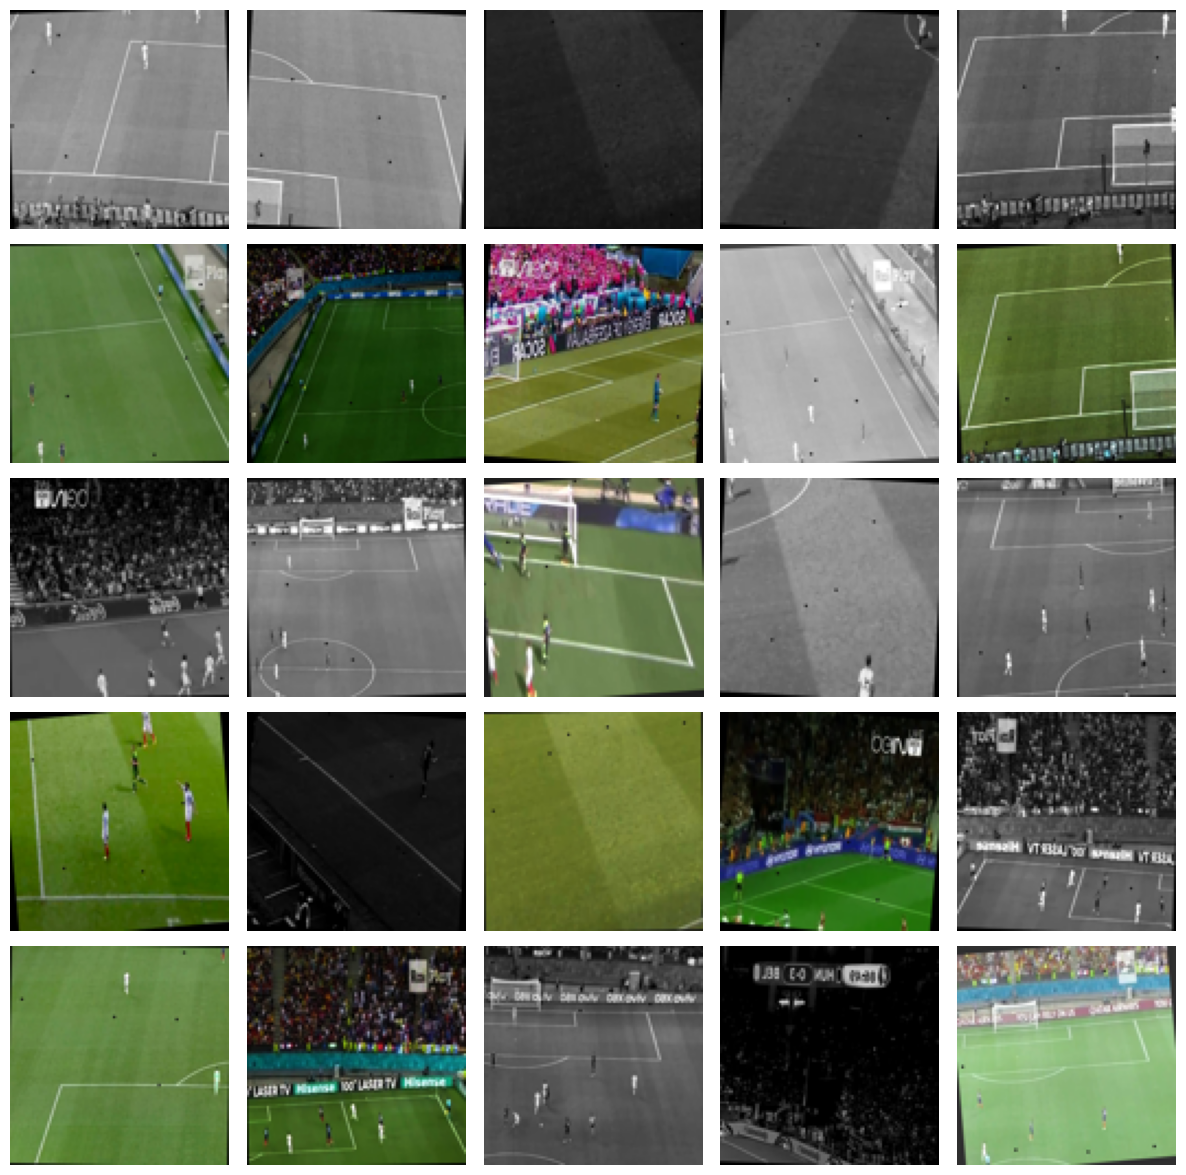

In [ ]:
grid_size = 5
num_images = 25
image_directory = dataset_dir + 'train/images'

show_images_in_grid(image_directory, grid_size, num_images)

### b. Метрики качества

В качестве метрик для данной задачи будут использоваться:

$$ 
\text{mAP50} = \frac{1}{N} \sum_{i=1}^{N} \text{AP}_i 
$$

- Mean Average Precision at IoU=0.5 (mAP50) - средняя точность модели при пороге перекрытия (IoU) 0.5. Для каждой категории объектов вычисляется Average Precision (AP), и затем берется среднее значение AP для всех категорий.

$$ 
\text{mAP50-95} = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{10} \sum_{j=0}^{9} \text{AP}_{ij} 
$$

- Mean Average Precision at IoU from 0.5 to 0.95 (mAP50-95) - средняя точность модели на диапазоне IoU от 0.5 до 0.95 с шагом 0.05. Это более строгая метрика, учитывающая различные уровни перекрытия.

$$ 
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} 
$$

- Мера того, насколько правильно модель предсказывает положительные классы, где TP — количество истинно положительных предсказаний, а FP — количество ложноположительных предсказаний.

$$ 
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} 
$$

- Мера того, насколько хорошо модель находит все положительные классы, где FN — количество ложноотрицательных предсказаний.

## 2. Создание бейзлайна и оценка качества

Проведем сначала дообучение модели на стандартных параметрах и 10 эпохах.

In [3]:
import os
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/p.elistratova/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [39]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
yaml_path = "./football-player-detection-yolov8/football_players_detection/football_players_detection/data.yaml"


model = YOLO("yolov8n.pt")

model.info()

results = model.train(data=yaml_path, epochs=10, verbose=True)

YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./football-player-detection-yolov8/football_players_detection/football_players_detection/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, 

100%|██████████| 755k/755k [00:00<00:00, 22.5MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1630.5±972.9 MB/s, size: 134.2 KB)


train: Scanning /content/football-player-detection-yolov8/football_players_detection/football_players_detection/train/labels... 10308 images, 623 backgrounds, 0 corrupt: 100%|██████████| 10308/10308 [00:04<00:00, 2548.73it/s]


train: New cache created: /content/football-player-detection-yolov8/football_players_detection/football_players_detection/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1242.7±971.4 MB/s, size: 158.4 KB)


val: Scanning /content/football-player-detection-yolov8/football_players_detection/football_players_detection/valid/labels... 972 images, 30 backgrounds, 0 corrupt: 100%|██████████| 972/972 [00:00<00:00, 1034.73it/s]

val: New cache created: /content/football-player-detection-yolov8/football_players_detection/football_players_detection/valid/labels.cache


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.13G      1.434      1.367      1.128         17        640: 100%|██████████| 645/645 [03:25<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


                   all        972       5407      0.831      0.566      0.628      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.63G      1.394     0.9353      1.126         14        640: 100%|██████████| 645/645 [03:19<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.71it/s]

                   all        972       5407      0.851      0.584      0.657      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.64G      1.365     0.8589      1.124         16        640: 100%|██████████| 645/645 [03:17<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.71it/s]


                   all        972       5407      0.872      0.613      0.687      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.65G       1.33     0.8024      1.105         16        640: 100%|██████████| 645/645 [03:17<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.72it/s]


                   all        972       5407      0.862       0.63      0.707      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.66G      1.281     0.7416      1.083         21        640: 100%|██████████| 645/645 [03:19<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.67it/s]

                   all        972       5407      0.855      0.663      0.724      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.69G      1.249     0.7057      1.068         22        640: 100%|██████████| 645/645 [03:18<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.71it/s]


                   all        972       5407      0.784      0.705       0.76      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.71G      1.219      0.675      1.054          8        640: 100%|██████████| 645/645 [03:17<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.67it/s]

                   all        972       5407      0.875      0.676      0.754      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.72G      1.187     0.6439      1.042         16        640: 100%|██████████| 645/645 [03:18<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.70it/s]

                   all        972       5407      0.917      0.665      0.777       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.73G      1.154     0.6179      1.028          5        640: 100%|██████████| 645/645 [03:16<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


                   all        972       5407      0.847      0.716       0.79      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.76G      1.127     0.5897      1.015         16        640: 100%|██████████| 645/645 [03:17<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.69it/s]

                   all        972       5407      0.865      0.703      0.784      0.491



10 epochs completed in 0.586 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


                   all        972       5407      0.865      0.704      0.784      0.491
              football        241        275      0.817      0.486       0.62      0.323
                player        936       5132      0.912      0.922      0.948      0.659
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train4


Посмотрим на результаты обучения на валидационной выборке.

In [18]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1564.8±1173.4 MB/s, size: 87.7 KB)


val: Scanning /content/football-player-detection-yolov8/football_players_detection/football_players_detection/valid/labels.cache... 972 images, 30 backgrounds, 0 corrupt: 100%|██████████| 972/972 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:14<00:00,  4.17it/s]


                   all        972       5407      0.878      0.702      0.786      0.494
              football        241        275      0.841      0.484      0.625      0.327
                player        936       5132      0.915      0.921      0.948      0.661
Speed: 0.7ms preprocess, 4.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train42
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c9a93f2dc90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,   

In [37]:
print("< Результаты валидации >")
print("------------------------")
print(f"| Precision: {metrics.results_dict['metrics/precision(B)']:.3f}     |")
print(f"| Recall: {metrics.results_dict['metrics/recall(B)']:.3f}        |")
print(f"| mAP50: {metrics.results_dict['metrics/mAP50(B)']:.3f}         |")
print(f"| mAP50-95: {metrics.results_dict['metrics/mAP50-95(B)']:.3f}      |")
print("------------------------")

< Результаты валидации >
------------------------
| Precision: 0.878     |
| Recall: 0.702        |
| mAP50: 0.786         |
| mAP50-95: 0.494      |
------------------------


Модель показывает хорошие средние значения метрик на валидационной выборке. Можно увидеть что точность определения футболиста на поле выше 90%. Посмотрим удастся ли добиться еще лучших результатов, немного изменив параметры обучения.

## 3. Улучшение бейзлайна

Повысить значения метрик при обучении могут помочь следующие способы:

* Аугментация данных

Для увеличения количества входных данных и улучшения обучения моделей можно расширить датасет путем применения горизонтального/вертикального отражения, случайных поворотов, масштабирования, изменения яркости и контраста, обрезки и наложения шумов.

* Настройка гиперпараметров

Изменение learning rate, применение более продвинутых оптимизаторов и функций потерь, увеличение количества эпох обучения могут также способствовать улучшению результатов.

Зададим новые параметры обучения модели.

In [ ]:
yaml_path = "./football-player-detection-yolov8/football_players_detection/football_players_detection/data.yaml"

improved_model = YOLO("yolov8n.pt")

improved_results = improved_model.train(data=yaml_path, device=device,
                      epochs=20,  # Увеличим количество эпох до 20
                      batch=32,  # Размер мини-батча
                      lr0=0.01,  # Начальная скорость обучения
                      lrf=0.1,  # Конечная скорость обучения
                      momentum=0.937,  # Параметр инерции для оптимизатора
                      weight_decay=0.0005,  # Регуляризация L2 (предотвращает переобучение)
                      warmup_epochs=3,  # Количество эпох разогрева
                      imgsz=640,  # Размер входного изображения
                      augment=True)  # Применение аугментации

engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./football-player-detection-yolov8/football_players_detection/football_players_detection/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile

train: Scanning /content/football-player-detection-yolov8/football_players_detection/football_players_detection/train/labels.cache... 10308 images, 623 backgrounds, 0 corrupt: 100%|██████████| 10308/10308 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 919.4±827.7 MB/s, size: 158.4 KB)


val: Scanning /content/football-player-detection-yolov8/football_players_detection/football_players_detection/valid/labels.cache... 972 images, 30 backgrounds, 0 corrupt: 100%|██████████| 972/972 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.38G      1.433      1.364      1.102         28        640: 100%|██████████| 323/323 [03:24<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        972       5407      0.817      0.592      0.646      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.14G      1.391     0.9485      1.099         19        640: 100%|██████████| 323/323 [03:22<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


                   all        972       5407      0.857      0.618      0.679      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.14G      1.379     0.8795      1.098         23        640: 100%|██████████| 323/323 [03:18<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]

                   all        972       5407      0.859      0.618      0.695       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.14G      1.352     0.8414      1.089         29        640: 100%|██████████| 323/323 [03:20<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]

                   all        972       5407      0.781      0.643      0.694      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.14G      1.337     0.8223      1.087         10        640: 100%|██████████| 323/323 [03:19<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


                   all        972       5407      0.885      0.638      0.711      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.14G      1.309     0.7817      1.075         22        640: 100%|██████████| 323/323 [03:18<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]

                   all        972       5407      0.861      0.638      0.698      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.14G      1.287     0.7583      1.063         40        640: 100%|██████████| 323/323 [03:20<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


                   all        972       5407      0.872      0.654      0.748      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.14G       1.26     0.7312      1.052         31        640: 100%|██████████| 323/323 [03:21<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


                   all        972       5407      0.841      0.687      0.743      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.14G      1.241     0.7191      1.046         22        640: 100%|██████████| 323/323 [03:20<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.44it/s]


                   all        972       5407      0.862        0.7      0.772      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.14G      1.234     0.7051      1.041         18        640: 100%|██████████| 323/323 [03:18<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        972       5407      0.897      0.698      0.771      0.475
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.14G      1.198      0.651      1.046         11        640: 100%|██████████| 323/323 [03:13<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]

                   all        972       5407      0.875      0.687      0.752      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.14G      1.172     0.6319      1.039         17        640: 100%|██████████| 323/323 [03:10<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]

                   all        972       5407      0.876      0.711       0.78      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.14G       1.15     0.6167       1.03         14        640: 100%|██████████| 323/323 [03:10<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        972       5407      0.882      0.692      0.768       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.14G      1.137      0.604      1.023          8        640: 100%|██████████| 323/323 [03:09<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]

                   all        972       5407      0.902      0.698       0.79      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.14G      1.117     0.5892      1.016         11        640: 100%|██████████| 323/323 [03:11<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all        972       5407      0.916       0.71      0.807      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      5.14G      1.102     0.5768       1.01         23        640: 100%|██████████| 323/323 [03:10<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]


                   all        972       5407      0.896      0.721      0.806      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.14G      1.092      0.568      1.005          8        640: 100%|██████████| 323/323 [03:12<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


                   all        972       5407      0.867      0.733      0.801      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.14G      1.078     0.5557      1.001         18        640: 100%|██████████| 323/323 [03:12<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]

                   all        972       5407      0.909      0.728      0.817      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.14G       1.06     0.5422     0.9952         10        640: 100%|██████████| 323/323 [03:11<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]

                   all        972       5407      0.911      0.731      0.812      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      5.14G      1.049     0.5312      0.989         11        640: 100%|██████████| 323/323 [03:13<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


                   all        972       5407      0.876      0.744       0.81      0.519

20 epochs completed in 1.157 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.02s/it]


                   all        972       5407      0.903       0.71      0.801       0.51
              football        241        275      0.885      0.505      0.656      0.348
                player        936       5132       0.92      0.915      0.947      0.671
Speed: 0.3ms preprocess, 7.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train5


Проведем оценку обучения модели на тестовой выборке.

In [42]:
improved_metrics = improved_model.val()

Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1937.4±1115.9 MB/s, size: 87.7 KB)


val: Scanning /content/football-player-detection-yolov8/football_players_detection/football_players_detection/valid/labels.cache... 972 images, 30 backgrounds, 0 corrupt: 100%|██████████| 972/972 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:19<00:00,  1.55it/s]


                   all        972       5407      0.901      0.709        0.8      0.512
              football        241        275      0.879      0.502      0.653      0.351
                player        936       5132      0.923      0.916      0.948      0.673
Speed: 0.7ms preprocess, 10.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train52


In [43]:
print("< Результаты валидации >")
print("------------------------")
print(f"| Precision: {improved_metrics.results_dict['metrics/precision(B)']:.3f}     |")
print(f"| Recall: {improved_metrics.results_dict['metrics/recall(B)']:.3f}        |")
print(f"| mAP50: {improved_metrics.results_dict['metrics/mAP50(B)']:.3f}         |")
print(f"| mAP50-95: {improved_metrics.results_dict['metrics/mAP50-95(B)']:.3f}      |")
print("------------------------")

< Результаты валидации >
------------------------
| Precision: 0.901     |
| Recall: 0.709        |
| mAP50: 0.800         |
| mAP50-95: 0.512      |
------------------------


Результаты показывают увеличение всех метрик оценки, что подтверждает эффективность предложенных улучшений. 

## Выводы

В данной лабораторной работе было проведено исследований моделей обнаружения и распознавания объектов. Удалось добиться очень хороших результатов, дообучив модель YOLOv8 на данных футбольных матчей. Модель с улучшенным бейзлайном обладает высокой точностью и предсказывает мячи и людей на поле с вероятностью 90%!